In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from readlif.reader import LifFile
from skimage import draw
import copy
from scipy.ndimage import gaussian_filter
import matplotlib.patches as mpatches

#insert the file address at your computer
fpath = 'D:/Fernanda Leomil/Doutorado.Biofisica.Unifesp/Max Planck/Results/Quenching/'

#inser the name of the .lif file
fname ='1min_quench' #video name

fext = '.lif' #video extension
fullpath = fpath + fname + fext

#px size in meters
pxsize=0.0000000947

How many measurements would you like to do?4
mean fluorescence intensity: 2.3083124999999998e-05


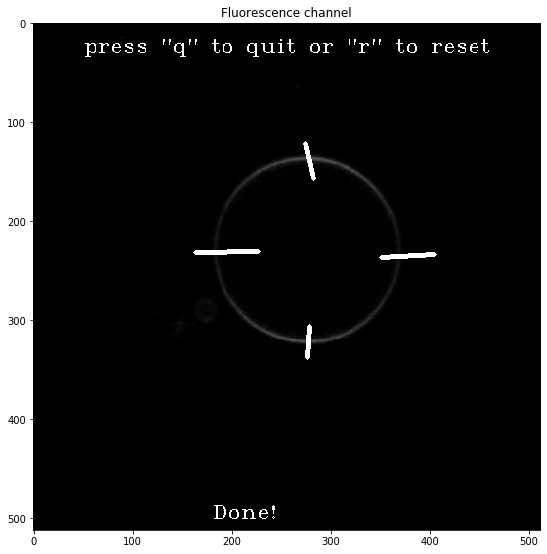

In [8]:
######################################### Open fluorescence channel of GUV of interest #########################################

new = LifFile(fullpath)
#Open the GUV of interest:  new.get_image(n). n=0 is the first GUV; n=5 is the sixth GUV of the .lif file
img = new.get_image(0)

#Gets the specified frame (z, t, c, m) from image. c=0 is the fluorescence channel
fluo=img.get_frame(z=0, t=0, c=0)

#image_fluo contains the fluorescent image as an array
image_fluo=np.array(fluo)
#apply gaussian filter
image_fluo=gaussian_filter(image_fluo, sigma=1)


#Create deep copy - clean image just to exhibit
image_fluo_copy = copy.deepcopy(image_fluo)


#How many lines do you want to draw? Miminum of 4 is recommended.
number_meas = int(input("How many measurements would you like to do?"))
#print('you can draw',number_meas,'lines')


################################################## Draw line using fluo channel#################################################
import copy
text = 'press "q" to quit or "r" to reset'
font = cv2.FONT_HERSHEY_COMPLEX_SMALL
org = (50, 30) 
fontScale = 1
color = [255,255,255] 
thickness = 1

def on_mouse(event, x, y, flags, params):
    global image_fluo, image_fluo_copy, r_start, c_start,r_end, c_end, data,eixo_x, meas_taken, data_list,coords
    
    if(event == cv2.EVENT_LBUTTONDOWN):
        r_start = x
        c_start = y
        #print('Start Mouse Position: '+str(x)+', '+str(y))
    elif (event == cv2.EVENT_LBUTTONUP):
        r_end = x
        c_end = y
        #print ('End Mouse Position: '+str(x)+', '+str(y))
        image_fluo = cv2.line(image_fluo, (r_start, c_start), (r_end, c_end), (255, 255, 255), 3)
        line = np.transpose(np.array(draw.line(r_start, c_start, r_end, c_end)))
        data = image_fluo_copy[line[:, 1], line[:, 0]]
        coords[meas_taken]=[r_start,c_start,r_end,c_end]
        data_list.append(data)
        meas_taken += 1
        

# Making Window For The Image
cv2.namedWindow("image_fluo_channel")
# Adding Mouse CallBack Event

cv2.setMouseCallback("image_fluo_channel",on_mouse)
#data_list contains all the px values from the lines that were drawn 
data_list = []
#coords contains the coordinates of each line 
coords = np.zeros((number_meas,4))
meas_taken = 0

# Loop until the 'q' key is pressed
while True:

    # Display image; wait for keypress
    image = cv2.putText(image_fluo, text, org, font, fontScale,color, thickness)
    cv2.imshow("image_fluo_channel", image_fluo, )
    key = cv2.waitKey(1) & 0xFF
    
    if(meas_taken==number_meas):
        cv2.setMouseCallback("image_fluo_channel",lambda *args : None)
        image = cv2.putText(image_fluo, 'Done!', (180, 500) , font, fontScale,color, thickness)
    # press q to close the drawing window
    if  key == ord("q"):
        break
    #press r to reset lines and draw again
    if key == ord("r"):
        image_fluo = image_fluo_copy.copy()
        r_start = 0
        c_start = 0
        r_end = 0
        c_end = 0
        cv2.setMouseCallback("image_fluo_channel",on_mouse)
        meas_taken = 0

cv2.destroyAllWindows()

    
#plot
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(image_fluo,cmap='gray',vmin=1)
plt.title('Fluorescence channel')

k=0
#index where one can find the max intensity value 
index_max_values=np.zeros(number_meas)
#array to store the max values of each line
max_values=np.zeros(number_meas)

for k in range (number_meas):
    index_max_values[k]=np.argmax(data_list[k])
    max_values[k]=data_list[k][int(index_max_values[k])]
#print('index max',index_max_values)
#print('max values',max_values)

#finding the minimum value in each line
#data_min_array contains the minimum values from the left and right in relation to the maximum value, of each line
data_min_array=np.zeros((number_meas,2))
data_indexmin_array=np.zeros((number_meas,2))
for j in range(number_meas):
    data_min_array[j,0]=np.amin(data_list[j][:int(index_max_values[j])])
    data_min_array[j,1]=np.amin(data_list[j][int(index_max_values[j]):])
    data_indexmin_array[j,1]=np.argwhere(data_list[j][int(index_max_values[j]):]==data_min_array[j,1])[0] + len(data_list[j][:int(index_max_values[j])])
    data_indexmin_array[j,0]=np.argwhere(data_list[j][:int(index_max_values[j])][::-1]==data_min_array[j,0])[0]
    data_indexmin_array[j,0]=len(data_list[j][:int(index_max_values[j])])-data_indexmin_array[j,0]-1
#print('minimum values in each line to the left and right',data_min_array)
#print('positions of the minima in the large vector left and right',data_indexmin_array)
     
    
#calculatin the integral under each peak
integral_peaks_nbd=np.zeros(number_meas)
u=0
for u in range(number_meas):
    
    integral_peaks_nbd[u]=np.sum(data_list[u][int(data_indexmin_array[u,0]):int(data_indexmin_array[u,1])])*pxsize
    
#print(integral_peaks_nbd)
#print(integral_peaks_fret)

mean_nbd=np.mean(integral_peaks_nbd)

#print(mean_nbd)
#print(mean_fret)
print('mean fluorescence intensity:',mean_nbd)

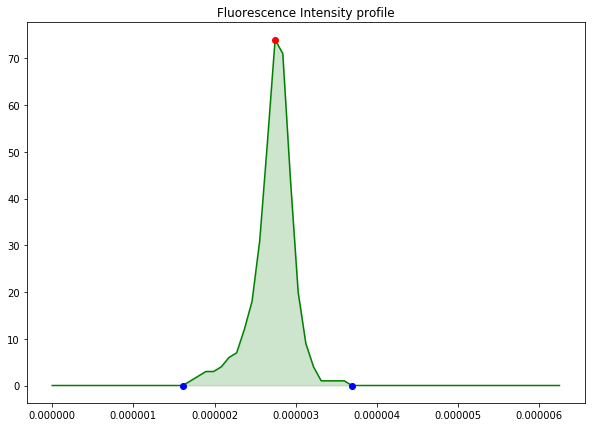

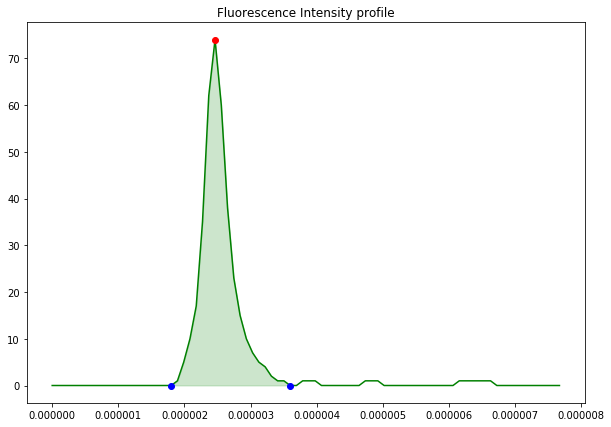

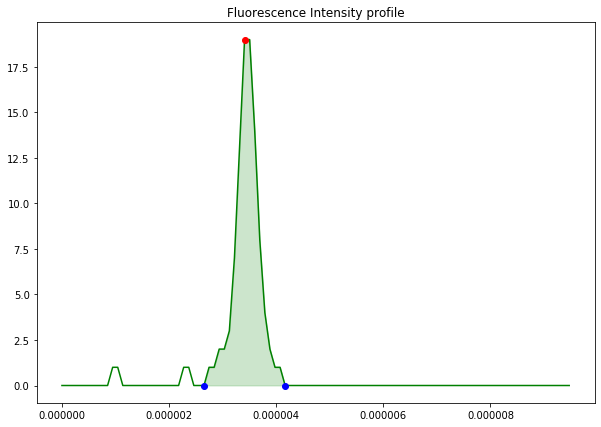

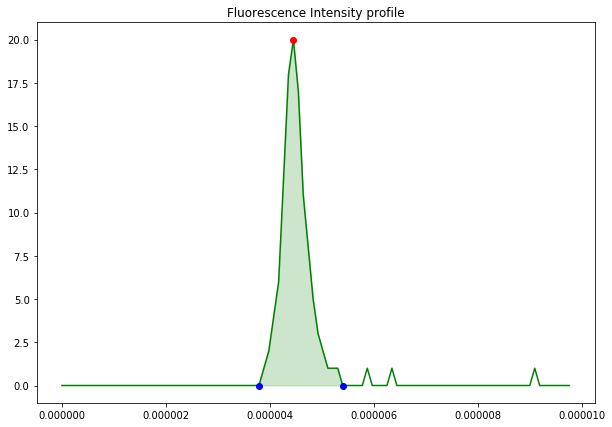

In [5]:
#############################################intensity profile plot of each linel###############################################
i=0
for i in range (number_meas):
    eixo_x=(np.arange(len(data_list[i])))*pxsize
    plt.figure(figsize=(10, 7))
    #Ifluo
    plt.plot(eixo_x,data_list[i], '-g')
    #max point 
    plt.plot(eixo_x[int(index_max_values[i])],max_values[i],'ro')
    #left min point
    plt.plot(eixo_x[int(data_indexmin_array[i,0])],data_list[i][int(data_indexmin_array[i,0])],'bo')
    #right min point
    plt.plot(eixo_x[int(data_indexmin_array[i,1])],data_list[i][int(data_indexmin_array[i,1])],'bo')
    plt.title('Fluorescence Intensity profile')
    plt.fill_between(eixo_x[int(data_indexmin_array[i,0]):int(data_indexmin_array[i,1])+1],data_list[i][int(data_indexmin_array[i,0]):int(data_indexmin_array[i,1])+1],color='green',alpha=0.2 )
    plt.show()
    
    #print('line',i+1)
    i=i+1